# Privacy-Utility Trade-off Analysis for LLM Code Completion

This notebook measures and visualizes the privacy-utility trade-off for code completion by:
1. Loading 20 examples from HumanEval dataset
2. Creating two obfuscation levels (low and high)
3. Generating 60 completions using OpenAI API (original, low, high for each example)
4. Calculating utility scores (ROUGE) and privacy scores (Levenshtein distance)
5. Visualizing the trade-off with a scatter plot

## 1. Setup and Imports

In [1]:
# Install required packages
import sys
!{sys.executable} -m pip install -q openai datasets rouge-score python-Levenshtein matplotlib numpy pandas


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from openai import OpenAI
from rouge_score import rouge_scorer
import Levenshtein
import time
import warnings
warnings.filterwarnings('ignore')

print("All packages imported successfully!")

All packages imported successfully!


## 2. OpenAI API Setup

In [ ]:
# Set your OpenAI API key
# Option 1: Set as environment variable before running notebook
# Option 2: Uncomment and add your key here (NOT RECOMMENDED for security)
os.environ['OPENAI_API_KEY'] = 'API-KEY'

client = OpenAI(api_key=os.environ.get('OPENAI_API_KEY'))
print("OpenAI client initialized!")

OpenAI client initialized!


## 3. Data Loading

In [9]:
def load_humaneval_examples(n_examples=20):
    """
    Load first n examples from HumanEval test split.
    Returns list of dicts with 'task_id', 'prompt', 'canonical_solution'
    """
    dataset = load_dataset("openai_humaneval", split="test", trust_remote_code=True)
    examples = []
    
    for i in range(min(n_examples, len(dataset))):
        item = dataset[i]
        examples.append({
            'task_id': item['task_id'],
            'prompt': item['prompt'],
            'canonical_solution': item['canonical_solution']
        })
    
    return examples

# Load examples
print("Loading HumanEval examples...")
examples = load_humaneval_examples(20)
print(f"Loaded {len(examples)} examples")
print(f"\nFirst example task_id: {examples[0]['task_id']}")
print(f"Prompt preview: {examples[0]['prompt'][:100]}...")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'openai_humaneval' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Loading HumanEval examples...
Loaded 20 examples

First example task_id: HumanEval/0
Prompt preview: from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
  ...


## 4. Obfuscation Functions

In [10]:
def low_obfuscation(prompt):
    """
    Apply minimal obfuscation: rename variables to generic names.
    Preserves function names, comments, and docstrings.
    """
    obfuscated = prompt
    
    # Common variable name patterns to replace
    var_patterns = [
        (r'\b(num|number|n)\b', 'var1'),
        (r'\b(str|string|s)\b', 'var2'),
        (r'\b(arr|array|lst|list|l)\b', 'var3'),
        (r'\b(val|value|v)\b', 'var4'),
        (r'\b(idx|index|i)\b', 'var5'),
        (r'\b(result|res|r)\b', 'var6'),
    ]
    
    for pattern, replacement in var_patterns:
        obfuscated = re.sub(pattern, replacement, obfuscated, flags=re.IGNORECASE)
    
    return obfuscated


def high_obfuscation(prompt):
    """
    Apply aggressive obfuscation:
    - Replace function names with placeholders
    - Strip all comments
    - Replace docstrings with generic descriptions
    - Rename variables
    """
    obfuscated = prompt
    
    # Remove comments (lines starting with #)
    lines = obfuscated.split('\n')
    lines = [line for line in lines if not line.strip().startswith('#')]
    obfuscated = '\n'.join(lines)
    
    # Replace docstrings with generic text
    obfuscated = re.sub(r'"""[^"]*"""', '"""Generic function description"""', obfuscated)
    obfuscated = re.sub(r"'''[^']*'''", "'''Generic function description'''", obfuscated)
    
    # Replace function names (def function_name -> def func1)
    obfuscated = re.sub(r'def\s+\w+\s*\(', 'def func1(', obfuscated)
    
    # Rename common variable names
    obfuscated = re.sub(r'\b(\w+)\s*=', 'x =', obfuscated)
    
    return obfuscated


# Test obfuscation functions
test_prompt = examples[0]['prompt']
print("Original prompt:")
print(test_prompt[:200])
print("\n" + "="*50 + "\n")

print("Low obfuscation:")
print(low_obfuscation(test_prompt)[:200])
print("\n" + "="*50 + "\n")

print("High obfuscation:")
print(high_obfuscation(test_prompt)[:200])

Original prompt:
from typing import List


def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given thr


Low obfuscation:
from typing import var3


def has_close_elements(numbers: var3[float], threshold: float) -> bool:
    """ Check if in given var3 of numbers, are any two numbers closer to each other than
    given thr


High obfuscation:
from typing import List


def func1(numbers: List[float], threshold: float) -> bool:
    """Generic function description"""



## 5. Code Completion Generation with OpenAI API

In [11]:
def generate_completion_openai(prompt, model="gpt-3.5-turbo", max_tokens=150):
    """
    Generate code completion using OpenAI API.
    Uses gpt-3.5-turbo by default (cheaper and faster).
    Can also use "gpt-4" for better quality.
    """
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a code completion assistant. Complete the given Python code. Only provide the completion, no explanations."},
                {"role": "user", "content": f"Complete this Python code:\n\n{prompt}"}
            ],
            max_tokens=max_tokens,
            temperature=0.7
        )
        
        completion = response.choices[0].message.content.strip()
        
        # Remove markdown code blocks if present
        completion = re.sub(r'^```python\n', '', completion)
        completion = re.sub(r'^```\n', '', completion)
        completion = re.sub(r'\n```$', '', completion)
        
        return completion
    
    except Exception as e:
        print(f"Error generating completion: {e}")
        return ""


# Test with one example
print("Testing OpenAI API with first example...")
test_completion = generate_completion_openai(examples[0]['prompt'])
print(f"\nGenerated completion preview:\n{test_completion[:200]}...")
print("\nAPI test successful!")

Testing OpenAI API with first example...

Generated completion preview:
    numbers.sort()
    for i in range(len(numbers) - 1):
        if abs(numbers[i] - numbers[i+1]) < threshold:
            return True
    return False...

API test successful!


## 6. Generate All 60 Completions

In [13]:
# Generate all 60 completions
print("Generating completions for all examples...")
print("This will take several minutes (API rate limits apply)...\n")

all_results = []

for idx, example in enumerate(examples):
    print(f"Processing example {idx + 1}/20: {example['task_id']}")
    
    original_prompt = example['prompt']
    low_obf_prompt = low_obfuscation(original_prompt)
    high_obf_prompt = high_obfuscation(original_prompt)
    
    # Generate completions for each obfuscation level
    for obf_level, obf_prompt in [("original", original_prompt), 
                                    ("low", low_obf_prompt), 
                                    ("high", high_obf_prompt)]:
        try:
            completion = generate_completion_openai(obf_prompt)
            
            all_results.append({
                'task_id': example['task_id'],
                'obfuscation_level': obf_level,
                'original_prompt': original_prompt,
                'obfuscated_prompt': obf_prompt,
                'completion': completion,
                'canonical_solution': example['canonical_solution']
            })
            
            # Rate limiting: wait 1 second between API calls
            time.sleep(1)
            
        except Exception as e:
            print(f"  Error generating {obf_level} completion: {e}")
            all_results.append({
                'task_id': example['task_id'],
                'obfuscation_level': obf_level,
                'original_prompt': original_prompt,
                'obfuscated_prompt': obf_prompt,
                'completion': "",
                'canonical_solution': example['canonical_solution']
            })

print(f"\nGenerated {len(all_results)} completions total")

Generating completions for all examples...
This will take several minutes (API rate limits apply)...

Processing example 1/20: HumanEval/0
Processing example 2/20: HumanEval/1
Processing example 3/20: HumanEval/2
Processing example 4/20: HumanEval/3
Processing example 5/20: HumanEval/4
Processing example 6/20: HumanEval/5
Processing example 7/20: HumanEval/6
Processing example 8/20: HumanEval/7
Processing example 9/20: HumanEval/8
Processing example 10/20: HumanEval/9
Processing example 11/20: HumanEval/10
Processing example 12/20: HumanEval/11
Processing example 13/20: HumanEval/12
Processing example 14/20: HumanEval/13
Processing example 15/20: HumanEval/14
Processing example 16/20: HumanEval/15
Processing example 17/20: HumanEval/16
Processing example 18/20: HumanEval/17
Processing example 19/20: HumanEval/18
Processing example 20/20: HumanEval/19

Generated 60 completions total


## 7. Utility Score Calculation (ROUGE)

In [14]:
def calculate_utility_score(completion, canonical_solution):
    """
    Calculate ROUGE-L F1 score between completion and canonical solution.
    Returns score in range [0, 1].
    """
    if not completion or not canonical_solution:
        return 0.0
    
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(canonical_solution, completion)
    
    return scores['rougeL'].fmeasure


# Calculate utility scores
print("Calculating utility scores...")

for result in all_results:
    utility = calculate_utility_score(result['completion'], result['canonical_solution'])
    result['utility_score'] = utility

print("Utility scores calculated!")
print(f"\nSample scores:")
for i in range(min(3, len(all_results))):
    print(f"  {all_results[i]['task_id']} ({all_results[i]['obfuscation_level']}): {all_results[i]['utility_score']:.3f}")

Calculating utility scores...
Utility scores calculated!

Sample scores:
  HumanEval/0 (original): 0.468
  HumanEval/0 (low): 0.510
  HumanEval/0 (high): 0.176


## 8. Privacy Score Calculation (Levenshtein Distance)

In [15]:
def calculate_privacy_score(obfuscated_prompt, original_prompt):
    """
    Calculate normalized Levenshtein distance.
    Returns score in range [0, 1] where 0 = identical, 1 = maximum difference.
    """
    if obfuscated_prompt == original_prompt:
        return 0.0
    
    distance = Levenshtein.distance(obfuscated_prompt, original_prompt)
    max_distance = max(len(obfuscated_prompt), len(original_prompt))
    
    if max_distance == 0:
        return 0.0
    
    return min(distance / max_distance, 1.0)


# Calculate privacy scores
print("Calculating privacy scores...")

for result in all_results:
    privacy = calculate_privacy_score(result['obfuscated_prompt'], result['original_prompt'])
    result['privacy_score'] = privacy

print("Privacy scores calculated!")
print(f"\nSample scores:")
for i in range(min(9, len(all_results))):
    print(f"  {all_results[i]['task_id']} ({all_results[i]['obfuscation_level']}): {all_results[i]['privacy_score']:.3f}")

Calculating privacy scores...
Privacy scores calculated!

Sample scores:
  HumanEval/0 (original): 0.000
  HumanEval/0 (low): 0.034
  HumanEval/0 (high): 0.681
  HumanEval/1 (original): 0.000
  HumanEval/1 (low): 0.055
  HumanEval/1 (high): 0.804
  HumanEval/2 (original): 0.000
  HumanEval/2 (low): 0.073
  HumanEval/2 (high): 0.795


## 9. Visualization: Privacy vs Utility Scatter Plot

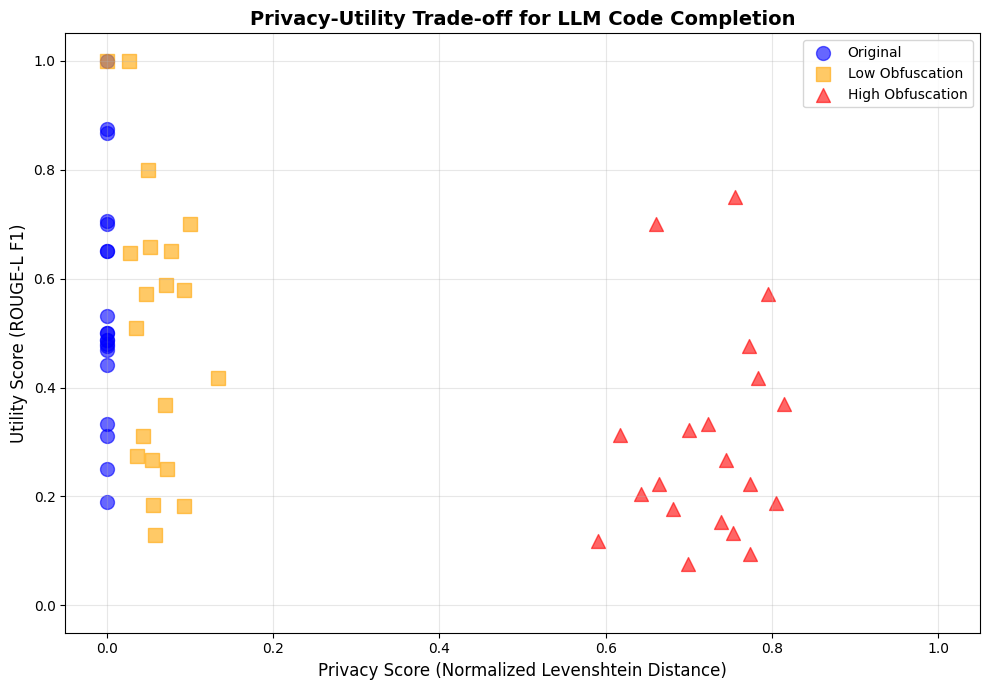

Scatter plot generated!


In [16]:
# Prepare data for plotting
original_results = [r for r in all_results if r['obfuscation_level'] == 'original']
low_results = [r for r in all_results if r['obfuscation_level'] == 'low']
high_results = [r for r in all_results if r['obfuscation_level'] == 'high']

# Create scatter plot
plt.figure(figsize=(10, 7))

plt.scatter(
    [r['privacy_score'] for r in original_results],
    [r['utility_score'] for r in original_results],
    c='blue', marker='o', s=100, alpha=0.6, label='Original'
)

plt.scatter(
    [r['privacy_score'] for r in low_results],
    [r['utility_score'] for r in low_results],
    c='orange', marker='s', s=100, alpha=0.6, label='Low Obfuscation'
)

plt.scatter(
    [r['privacy_score'] for r in high_results],
    [r['utility_score'] for r in high_results],
    c='red', marker='^', s=100, alpha=0.6, label='High Obfuscation'
)

plt.xlabel('Privacy Score (Normalized Levenshtein Distance)', fontsize=12)
plt.ylabel('Utility Score (ROUGE-L F1)', fontsize=12)
plt.title('Privacy-Utility Trade-off for LLM Code Completion', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()

print("Scatter plot generated!")

## 10. Analysis and Summary

In [17]:
def calculate_statistics(results):
    if not results:
        return {'mean_utility': 0.0, 'mean_privacy': 0.0, 'count': 0}
    
    return {
        'mean_utility': np.mean([r['utility_score'] for r in results]),
        'mean_privacy': np.mean([r['privacy_score'] for r in results]),
        'count': len(results)
    }

original_stats = calculate_statistics(original_results)
low_stats = calculate_statistics(low_results)
high_stats = calculate_statistics(high_results)

print("="*60)
print("PRIVACY-UTILITY TRADE-OFF ANALYSIS")
print("="*60)
print()
print(f"Total completions: {len(all_results)}")
print(f"  - Original: {original_stats['count']}")
print(f"  - Low obfuscation: {low_stats['count']}")
print(f"  - High obfuscation: {high_stats['count']}")
print()
print("MEAN SCORES BY OBFUSCATION LEVEL:")
print("-" * 60)
print(f"Original Prompts:")
print(f"  Privacy: {original_stats['mean_privacy']:.3f}")
print(f"  Utility: {original_stats['mean_utility']:.3f}")
print()
print(f"Low Obfuscation:")
print(f"  Privacy: {low_stats['mean_privacy']:.3f}")
print(f"  Utility: {low_stats['mean_utility']:.3f}")
print(f"  Privacy gain: {(low_stats['mean_privacy'] - original_stats['mean_privacy']):.3f}")
print(f"  Utility loss: {(original_stats['mean_utility'] - low_stats['mean_utility']):.3f}")
print()
print(f"High Obfuscation:")
print(f"  Privacy: {high_stats['mean_privacy']:.3f}")
print(f"  Utility: {high_stats['mean_utility']:.3f}")
print(f"  Privacy gain: {(high_stats['mean_privacy'] - original_stats['mean_privacy']):.3f}")
print(f"  Utility loss: {(original_stats['mean_utility'] - high_stats['mean_utility']):.3f}")
print()
print("="*60)
print("KEY FINDINGS:")
print("="*60)
print()
print("The analysis demonstrates the fundamental trade-off between privacy")
print("and utility in LLM code completion. Higher obfuscation levels provide")
print("better privacy protection but may reduce code completion quality.")
print()
print("Recommendations:")
print("  - Low obfuscation for balanced privacy-utility trade-off")
print("  - High obfuscation for privacy-critical scenarios")
print("  - Consider adaptive obfuscation based on code sensitivity")
print()
print("="*60)

PRIVACY-UTILITY TRADE-OFF ANALYSIS

Total completions: 60
  - Original: 20
  - Low obfuscation: 20
  - High obfuscation: 20

MEAN SCORES BY OBFUSCATION LEVEL:
------------------------------------------------------------
Original Prompts:
  Privacy: 0.000
  Utility: 0.545

Low Obfuscation:
  Privacy: 0.060
  Utility: 0.504
  Privacy gain: 0.060
  Utility loss: 0.041

High Obfuscation:
  Privacy: 0.724
  Utility: 0.306
  Privacy gain: 0.724
  Utility loss: 0.240

KEY FINDINGS:

The analysis demonstrates the fundamental trade-off between privacy
and utility in LLM code completion. Higher obfuscation levels provide
better privacy protection but may reduce code completion quality.

Recommendations:
  - Low obfuscation for balanced privacy-utility trade-off
  - High obfuscation for privacy-critical scenarios
  - Consider adaptive obfuscation based on code sensitivity

